

<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">


# Run inference in images

In this last step we run all images adquires through the two best models selected by highest F1-score and Recall

We transform the information outputed by the net into a georeferenced dataset and apply some operations to handle overlapping objects

# Setting paths and bools

DIR is where your project path is and RGB is to set if you are working with RGB or with panchromatic images

In [33]:
# %env DIR=/eos/jeodpp/data/projects/REFOCUS/data/swalim_v2

%env IN_DIR=/home3/idavis1/ekna_kiln_detect
%env OUT_DIR=/data4/shared/ekna_kiln_drive/test4

%env RGB=True

env: IN_DIR=/home3/idavis1/ekna_kiln_detect
env: OUT_DIR=/data4/shared/ekna_kiln_drive/test4
env: RGB=True


In [34]:
parcel = "p1_first50"

In [35]:
import sys
import os
syspath = f"{os.environ['HOME']}/ekna_kiln_detect/VerhegghenReplica/scripts/GDAL-python"
sys.path.append(syspath)
import shapefile
from pathlib import Path

# import some common libraries
import matplotlib.pyplot as plt
import cv2
from PIL import Image

from osgeo import osr, ogr, gdal


import json
import pandas as pd
import geopandas as gpd
import random
import glob
import shutil
import cv2
import numpy as np


# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg

# Import torch just to check that version & cuda are what we want
import torch

# Import psycopg2 for PostgreSQL manipulation
import psycopg2
from psycopg2 import sql
import subprocess

In [22]:
print(torch.__version__)

1.10.1


In [23]:
print(torch.cuda.is_available())

True


### Create the paths where we will save all data

This path also contains from the previous step the csv files with the final results

In [37]:
if os.getenv('RGB') == 'False':
    results_path = f"{os.getenv('OUT_DIR')}/{parcel}/pancro"
else:
    results_path = f"{os.getenv('OUT_DIR')}/{parcel}/RGB"
    
print(results_path)

/data4/shared/ekna_kiln_drive/test4/p1_first50/RGB


Some function to run the two best models for each dataset

In [41]:
def load_conf_file(path):
    config_file_path = path
    # The power value applied to image_count when calcualting frequency weight
    weights_path = "{}model_final.pth".format(path.split('config.yaml')[0])
    cfg = get_cfg()
    cfg.set_new_allowed(True)

    cfg.merge_from_file(config_file_path)
    cfg.DATASETS.TRAIN = ("swalim_train", )
    cfg.DATASETS.TEST = ("swalim_test", )
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    return cfg
    
def Inference(config, path_list_imgs, table, path_copy_im):
    cfg = load_conf_file(config)
    predictor = DefaultPredictor(cfg)

    with open(path_list_imgs) as f:
        lines = f.read().splitlines()

    for d in lines: 
        im = cv2.imread(d)
        outputs = predictor(im)  
        out = outputs["instances"].to("cpu")
        box = out.pred_boxes
        scores = out.scores
        classes = out.pred_classes.tolist() 
        boxes =  box.tensor.detach().numpy()
        print(boxes)
        if len(boxes>0):
            control = np.zeros((im.shape[0],im.shape[1]), dtype=int)
            for i in range(len(boxes)):
                control[int(boxes[i][1]): int(boxes[i][3]), int(boxes[i][0]): int(boxes[i][2]),] = 1

            name =  '{}{}'.format(path_copy_im, d.split('.tif')[0].split('/')[-1])
            shapefile.ArrayToPoly(d,control,name, path_copy_im, config, scores)
            
def Inference_all(t, df, withoutann = True, withann = True): 
    #if runned on another platform pick the path and change it,
    #if not directly df['Path']
    config = df['Path'].replace('/mnt/content/drive/MyDrive/JRC/Swalim_project/swalim_final_clean/outputs/second_iter/pancro_300/', results_path)
    
    #Inference on non annotated images
    if withoutann == True:
        if os.getenv('RGB') == 'False':
            orig_img_dir = f"{os.environ['IN_DIR']}/inputs/{parcel}/pancro/img_without_ann"
            path_list_imgs = f"{os.environ['IN_DIR']}/inputs/{parcel}/withoutann/list_tiles_pancro.csv"
            json_data_path = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/pancro_inf/pancro_inf_{t}.json"
            path_copy_im = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/pancro_inf_{t}/"
            table = f"pancro_{t}".format(t)

        else:
            orig_img_dir = f"{os.environ['IN_DIR']}/inputs/{parcel}/RGB/img_without_ann"
            path_list_imgs = f"{os.environ['IN_DIR']}/inputs/{parcel}/withoutann/list_tiles_RGB.csv"
            json_data_path = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/rgb_inf/rgb_inf_{t}.json"
            path_copy_im = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/rgb_inf_{t}/"
            table = f"rgb_{t}".format(t)
            
        #creating a new directory called pythondirectory
        Path(path_copy_im).mkdir(parents=True, exist_ok=True)
        Inference(config, path_list_imgs, table, path_copy_im)    

    #Inference on annotated images
    if withann == True:
        if os.getenv('RGB') == 'False':
            orig_img_dir = f"{os.environ['IN_DIR']}/inputs/{parcel}/pancro/img_without_ann"
            path_list_imgs = f"{os.environ['IN_DIR']}/inputs/{parcel}/withann/list_tiles_pancro.csv"
            json_data_path = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/pancro_inf/pancro_inf_{t}.json"
            path_copy_im = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/pancro_inf_{t}/"
            table = f"pancro_{t}"

        else:
            orig_img_dir = f"{os.environ['IN_DIR']}/inputs/{parcel}/RGB/img_without_ann"
            path_list_imgs = f"{os.environ['IN_DIR']}/inputs/{parcel}/withann/list_tiles_RGB.csv"
            json_data_path = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/rgb_inf/rgb_inf_{t}.json"
            path_copy_im = f"{os.environ['OUT_DIR']}/outputs/{parcel}/Inference/rgb_inf_{t}/"
            table = f"rgb_{t}"
            
        Path(path_copy_im).mkdir(parents=True, exist_ok=True)
        Inference(config, path_list_imgs, table, path_copy_im)

In [ ]:
''' # Equivalent to cell below

Inference(
    config = '/data4/shared/ekna_kiln_drive/test_inference/RGB/config.yaml',
    path_list_imgs = '/data4/shared/ekna_kiln_drive/test_inference/inputs/list_tiles_RGB.csv',
    table = 'rgb_null',
    path_copy_im = '/data4/shared/ekna_kiln_drive/test_inference/outputs/Inference/rgb_inf_null/'
)
'''

In [43]:
# Define inputs to Inference_all() & run
skip_inf_for_now = False

# How is config.yaml generated?
if os.getenv('RGB') == 'True':
    config_yml_path = "/data4/shared/ekna_kiln_drive/test_inference/RGB/config.yaml"
else:
    config_yml_path = "/data4/shared/ekna_kiln_drive/test_inference/pancro/config.yaml"


if skip_inf_for_now == False:
    t = "null"

    input_df = pd.DataFrame([{
        "Path": config_yml_path,
        # Additional fields expected by Inference_all #
    }])

    Inference_all(t, input_df.iloc[0], withann = False)
    

/home3/idavis1/miniconda3/envs/detectron2_tesla/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home3/idavis1/miniconda3/envs/detectron2_tesla/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[[ 99.44552  480.86053  106.244835 488.07693 ]]
/data4/shared/ekna_kiln_drive/test4/outputs/p1_first50/Inference/rgb_inf_null/FinalGeoms
0.5431245565414429
[[470.46103   34.285976 475.08517   38.93798 ]
 [133.74074  493.9766   142.39961  502.3944  ]]
/data4/shared/ekna_kiln_drive/test4/outputs/p1_first50/Inference/rgb_inf_null/FinalGeoms
0.9923938512802124
0.9741668105125427
[[ 99.00947  473.0459   107.97018  481.8912  ]
 [350.953    432.95102  359.9109   441.20554 ]
 [ 46.03991  177.51242   56.715584 187.75383 ]
 [446.31894  139.72836  456.8166   150.62906 ]
 [260.40475  361.2818   269.1577   369.6121  ]
 [248.48535   91.38149  257.32785  100.3836  ]
 [313.64542   40.03496  321.2262    48.69784 ]
 [414.28732  180.8043   424.5904   193.19025 ]
 [389.98172  345.22562  400.94943  355.44983 ]]
/data4/shared/ekna_kiln_drive/test4/outputs/p1_first50/Inference/rgb_inf_null/FinalGeoms
0.9883639812469482
0.9042431116104126
0.8002515435218811
0.7897340059280396
0.7483242750167847
0.690300881862

KeyboardInterrupt: 

## Run the code to inference in all the AOI!

In [ ]:
''' # Original code calling Inference_all/Inference

#select the bests models from the validation
results = pd.read_csv("{}/final_results.csv".format(results_path))
results = results.loc[:, ~results.columns.str.contains('^Unnamed')]

#select the best two models (f1score and recall)
f1_result = results.dropna().sort_values(by=['F_score'], ascending=False).iloc[0]
recall_result = results.dropna().sort_values(by=['Recall'], ascending=False).iloc[0]

#Inference for f-1score
t = 'f1score'
Inference_all(t, f1_result)

t = 'recall'
Inference_all(t, recall_result)
'''


#### Now we will do some of the geometrical operations to handle the overlappings between the tiles and datasets.
#### Everything will be upload to a postgres database.

In [15]:
# Define functions to export shapefile output to PostGIS database tables

# Function to export the shapefile with GDAL
def export_shapefile_to_postgis(shp_path, db_params, schema, table_name):
    try:
        # Build the connection string for PostGIS
        pg_connection = (
            f"PG:host={db_params['host']} "
            f"dbname={db_params['database']} "  # Change 'database' to 'dbname'
            f"user={db_params['user']} "
            f"password={db_params['password']} "
            f"port={db_params['port']}"
        )
        
        # Use ogr2ogr (via GDAL) to load the shapefile into the PostGIS database
        ogr_command = [
            "ogr2ogr",
            "-f", "PostgreSQL",
            pg_connection,
            shp_path,
            "-nln", f"{schema}.{table_name}",  # Target schema and table_name
            "-overwrite",  # Overwrite existing table_name
            "-lco", "GEOMETRY_NAME=wkb_geometry",  # Specify geometry column name
            "-lco", "FID=ogc_fid",  # Specify FID column name
            "-nlt", "PROMOTE_TO_MULTI"  # Convert to MultiPolygon if needed
        ]

        print(f"Running GDAL command: {' '.join(ogr_command)}")
        subprocess.run(ogr_command, check=True)
        print(f"Shapefile successfully exported to {schema}.{table_name}")
    
    except Exception as e:
        print(f"Error exporting shapefile to PostGIS: {e}")
        raise


# Function to verify the export in PostGIS using psycopg2
def verify_postgis_table(db_params, schema, table_name):
    try:
        # Connect to the PostGIS database
        connection = psycopg2.connect(**db_params)
        cursor = connection.cursor()

        # Query to check the number of rows and columns in the table_name
        sql = f'''
        SELECT COUNT(*), column_name, data_type FROM information_schema.columns
        WHERE table_schema = %s AND table_name = %s GROUP BY column_name, data_type;
        '''
        cursor.execute(sql, (schema, table_name))
        
        print(f"Table {schema}.{table_name} details:")
        for row in cursor.fetchall():
            print(row)

        cursor.close()
        connection.close()

    except Exception as e:
        print(f"Error verifying PostGIS Table: {e}")
        raise

##### Establish connection to database

In [35]:
#Postgres info connection:
user = "user2"
# user = "idavis1"
password = "3hfv62mZp$!BhYk"
host = "127.0.0.1"; print(f"Host IP: {host}")
port = "5432"
database = "postgres"

db_params = {
    "database": database,
    "user": user,
    "password": password,
    "host": host,
    "port": port
}

Host IP: 127.0.0.1


In [36]:
# Start PostgreSQL server
db_process = subprocess.Popen(
    ["postgres", "-D", "/data4/shared/ekna_kiln_drive/test_inference/test_db"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE,
    text=True
)

# Capture logs
print("PostgreSQL server started.")

PostgreSQL server started.


In [37]:
%%bash

# Check that server is started
ps aux | grep postgres
echo

# and listening
netstat -tuln | grep 5432 || echo "Port 5432 is not in use"

idavis1  121343  8.0  0.0 318088 18260 ?        S    18:05   0:00 postgres -D /data4/shared/ekna_kiln_drive/test_inference/test_db
idavis1  121344  0.0  0.0 171836  2308 ?        Ss   18:05   0:00 postgres: logger 
idavis1  121345  0.0  0.0 318232  2324 ?        Ss   18:05   0:00 postgres: checkpointer 
idavis1  121346  0.0  0.0 318224  2324 ?        Ss   18:05   0:00 postgres: background writer 
idavis1  121348  0.0  0.0 318224  2320 ?        Ss   18:05   0:00 postgres: walwriter 
idavis1  121349  0.0  0.0 319700  3352 ?        Ss   18:05   0:00 postgres: autovacuum launcher 
idavis1  121350  0.0  0.0 319684  3072 ?        Ss   18:05   0:00 postgres: logical replication launcher 
idavis1  121355  0.0  0.0 112824   968 ?        S    18:05   0:00 grep postgres

tcp        0      0 127.0.0.1:5432          0.0.0.0:*               LISTEN     
tcp6       0      0 ::1:5432                :::*                    LISTEN     


In [38]:
#connect to the database:

try:
    con = psycopg2.connect(
        user = user,
        password = password,
        host = host,
        port = port,
        database = database
        )
    print("Connection successful")
    cursor = con.cursor()
    con.set_session(autocommit=True)
    print("Connected.")
except Exception as e:
    print(f"Error connecting to database: {e}")

Connection successful
Connected.


In [20]:
# If database was just initialized, create 'ekna' schema and enable postgis 
init_schema_flag = False

if init_schema_flag == True:
    # Ensure the schema exists
    cursor.execute("CREATE SCHEMA IF NOT EXISTS ekna; CREATE EXTENSION IF NOT EXISTS postgis;")
    con.commit()

In [40]:
# Run the export and verification

# Path to the Shapefile
if os.getenv('RGB') == 'True':
    shp_path = "/data4/shared/ekna_kiln_drive/test_inference/outputs/Inference/rgb_inf_null/" #FinalGeoms.shp"
else:
    shp_path = "/data4/shared/ekna_kiln_drive/test_inference/outputs/Inference/pancro_inf_null/" #FinalGeoms.shp"

print(shp_path)
table_name = "pancro_input"  # Target table_name in PostGIS
schema = "ekna"  # Target schema in PostGIS

export_shapefile_to_postgis(shp_path, db_params, schema, table_name)
verify_postgis_table(db_params, schema, table_name)

/data4/shared/ekna_kiln_drive/test_inference/outputs/Inference/pancro_inf_null/
Running GDAL command: ogr2ogr -f PostgreSQL PG:host=127.0.0.1 dbname=postgres user=user2 password=3hfv62mZp$!BhYk port=5432 /data4/shared/ekna_kiln_drive/test_inference/outputs/Inference/pancro_inf_null/ -nln ekna.pancro_input -overwrite -lco GEOMETRY_NAME=wkb_geometry -lco FID=ogc_fid -nlt PROMOTE_TO_MULTI
Shapefile successfully exported to ekna.pancro_input
Table ekna.pancro_input details:
(1, 'ogc_fid', 'integer')
(1, 'proba', 'numeric')
(1, 'submitname', 'character varying')
(1, 'weightname', 'character varying')
(1, 'wkb_geometry', 'USER-DEFINED')


#### Create the final product

In [41]:
# give the name of the two tables with the results in postgres:
schema = "ekna"

# f1_score = "pancro_f1score"
# recall = "pancro_recall"

f1_score = "test_pancro"
recall = "test_pancro"

In [45]:
### Added for testing ###
# Drop the existing table if it exists
sql_drop = f'DROP TABLE IF EXISTS "{schema}".merged;'
cursor.execute(sql_drop)

sql_drop = f'DROP TABLE IF EXISTS "{schema}".pancro_final;'
cursor.execute(sql_drop)
#########################


sql = 'CREATE TABLE "{}".merged AS( SELECT * FROM "{}".{} p UNION SELECT * FROM  "{}".{} pb)'.format(\
            schema, schema, f1_score, schema, recall)
cursor.execute(sql)

sql = f'''
DELETE FROM "{schema}".merged c
WHERE c.ogc_fid IN (
    SELECT b.ogc_fid
    FROM "{schema}".merged a, "{schema}".merged b
    WHERE a.ogc_fid < b.ogc_fid
    AND ST_Intersects(a.wkb_geometry, b.wkb_geometry)
    AND ST_Area(ST_Intersection(a.wkb_geometry, b.wkb_geometry)) / ST_Area(a.wkb_geometry) > 0.5
);
'''

cursor.execute(sql)

if 'pancro' in recall:
    name = 'pancro'
else:
    name = 'rgb'

# sql = 'ALTER TABLE "{}".merged RENAME TO "{}".{}_final'.format(schema, schema, name)
sql = 'ALTER TABLE "{}".merged RENAME TO {}_final'.format(schema, name)
cursor.execute(sql)

# Compute area
sql = 'ALTER TABLE "{}".{}_final ADD COLUMN area double precision'.format(schema, name)
cursor.execute(sql)

sql = 'UPDATE "{}".{}_final SET area=ST_AREA("{}".{}_final.wkb_geometry)'.format(schema, name, schema, name)
cursor.execute(sql)

# Compute diameter
sql = 'ALTER TABLE "{}".{}_final ADD COLUMN diameter double precision'.format(schema, name)
cursor.execute(sql)

sql = 'UPDATE "{}".{}_final SET diameter=ST_Perimeter("{}".{}_final.wkb_geometry)/4'.format(schema, name, schema, name)
cursor.execute(sql)

In [ ]:
# Debug tools

# List schemas
cursor.execute("SELECT schema_name FROM information_schema.schemata;")
print(f"Schemas: {cursor.fetchall()}")

# List tables in the schema
cursor.execute(f"SELECT table_name FROM information_schema.tables WHERE table_schema = '{schema}';")
print(f"Tables in {schema}: {cursor.fetchall()}")

# Check for temporary tables in the pg_temp namespace
cursor.execute("SELECT tablename FROM pg_tables WHERE schemaname = 'pg_temp';")
print(f"Temporary tables: {cursor.fetchall()}\n")

table_i = "rgb_final"

# Check data types in a particular table
sql = f'''
SELECT column_name, data_type
FROM information_schema.columns
WHERE table_schema = '{schema}'
  AND table_name = '{table_i}';
'''

cursor.execute(sql)
    
rows = cursor.fetchall()
columns = ["column_name", "data_type"]
metadata = pd.DataFrame(rows, columns=columns)

print(f"Columns and types for {schema}.{table_i}:")
print(metadata)

# gdf = gpd.read_file(shp_path)

In [30]:
# Close connection to the database
con.close ()

# Stop the PostgreSQL server
if db_process.poll() is None:  # Check if db_process is running
    db_process.terminate() 
    print("PostgreSQL server stopped.")
else:
    print("Server is not running.")

PostgreSQL server stopped.


In [46]:
# SQL query to fetch the PostGIS table
if os.getenv('RGB') == 'True':
    table_i = "rgb_final"
else:
    table_i = "pancro_final"


gdf = gpd.read_postgis(f"SELECT * FROM {schema}.{table_i}", con, geom_col="wkb_geometry")

/home3/idavis1/miniconda3/envs/detectron2_tesla/lib/python3.9/site-packages/geopandas/io/sql.py:170: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(


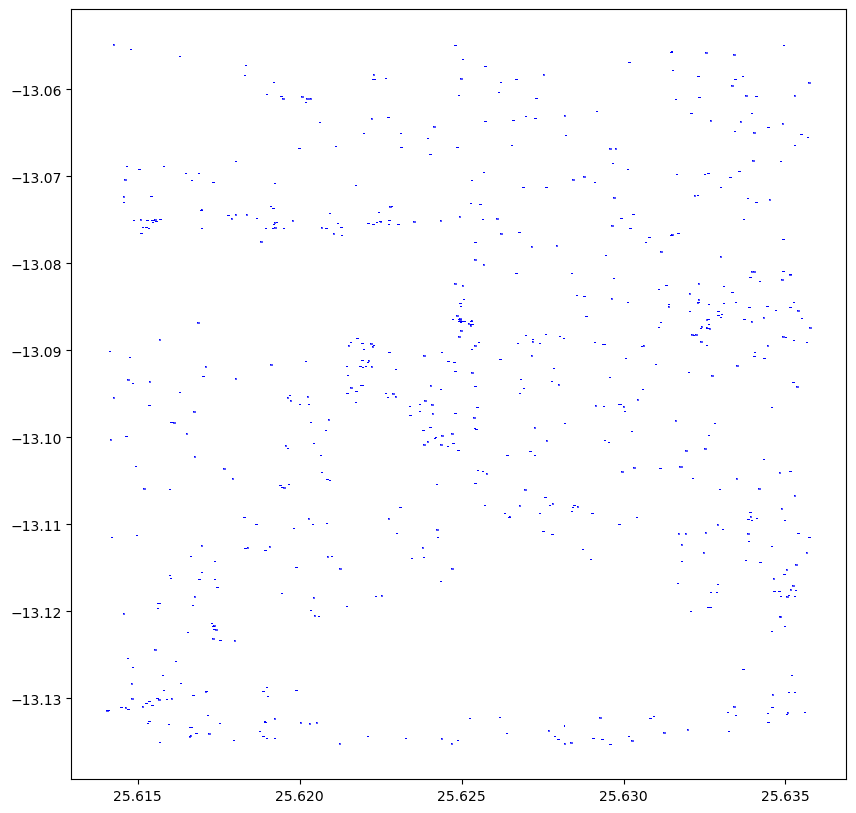

In [47]:
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon

fig, ax = plt.subplots(figsize=(10, 10))

for geom in gdf.wkb_geometry:
    if geom.is_empty:
        continue
    if isinstance(geom, MultiPolygon):
        # Access individual polygons using the .geoms attribute
        for polygon in geom.geoms:
            ax.plot(*polygon.exterior.xy, color="blue", linewidth=0.5)
    else:
        ax.plot(*geom.exterior.xy, color="blue", linewidth=0.5)

plt.show()


Bottom-left corner (latitude, longitude): (-13.13930043491727, 25.61294897514091)
Top-right corner (latitude, longitude): (-13.050788298619528, 25.636875290057635)


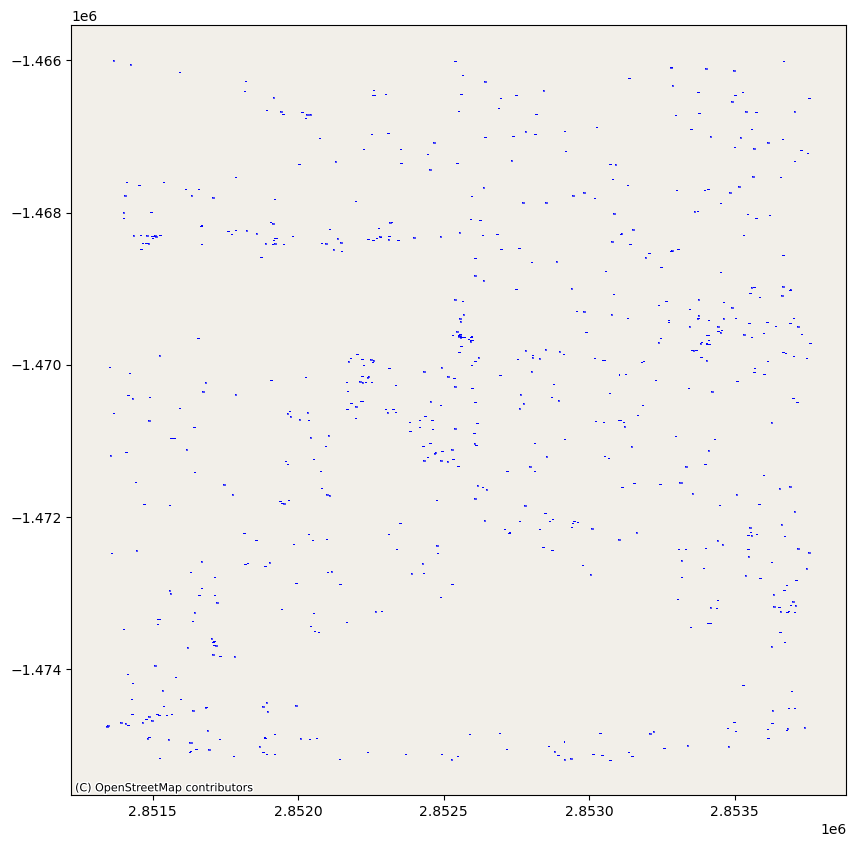

In [49]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import MultiPolygon
import contextily as ctx
from pyproj import Transformer

# Reproject GeoDataFrame to Web Mercator (EPSG:3857)
gdf = gdf.to_crs(epsg=3857)

fig, ax = plt.subplots(figsize=(10, 10))

# Plot
for geom in gdf.wkb_geometry:
    if geom.is_empty:
        continue
    if isinstance(geom, MultiPolygon):
        for polygon in geom.geoms:
            ax.plot(*polygon.exterior.xy, color="blue", linewidth=0.5)
    else:
        ax.plot(*geom.exterior.xy, color="blue", linewidth=0.5)

# Add OpenStreetMap tiles to the background
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Sanity check bottom-left corner lat/lon
xlim = ax.get_xlim()  # (min_x, max_x) -- Get plot bounds in Web Mercator (EPSG:3857)
ylim = ax.get_ylim()  # (min_y, max_y)
transformer = Transformer.from_crs("EPSG:3857", "EPSG:4326", always_xy=True)
lon_0, lat_0 = transformer.transform(xlim[0], ylim[0])
lon_1, lat_1 = transformer.transform(xlim[1], ylim[1])
print(f"Bottom-left corner (latitude, longitude): ({lat_0}, {lon_0})")
print(f"Top-right corner (latitude, longitude): ({lat_1}, {lon_1})")

plt.show()
